Importing the necessary dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
from tensorflow.keras.applications import ResNet50V2
import matplotlib.pyplot as plt



## Preprocessing the data

Using Image data generator for data augmentation of the dataset

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
CHANNEL = 3

#train data generator
tr_gen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.3,
    rotation_range = 0.4
)

#validation data generator
val_gen = ImageDataGenerator(
    rescale = 1./255
)
#test data generator
ts_gen = ImageDataGenerator(
    rescale = 1./255
)

Import data in tensorflow dataset

In [ ]:
#train dataset
trainDset = tr_gen.flow_from_directory(
    "/content/drive/MyDrive/leaf_data/train",
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse'
)

#validation dataset
valDset = val_gen.flow_from_directory(
    "/content/drive/MyDrive/leaf_data/val",
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse'
)

#test dataset
testDset = ts_gen.flow_from_directory(
    "/content/drive/MyDrive/leaf_data/test",
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,\
    class_mode = 'sparse'
)

Found 10159 images belonging to 16 classes.
Found 1447 images belonging to 16 classes.
Found 2914 images belonging to 16 classes.


In [ ]:
trainDset.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 4,
 'Corn_(maize)___Northern_Leaf_Blight': 5,
 'Corn_(maize)___healthy': 6,
 'Grape___Black_rot': 7,
 'Grape___Esca_(Black_Measles)': 8,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 9,
 'Grape___healthy': 10,
 'Pepper,_bell___Bacterial_spot': 11,
 'Pepper,_bell___healthy': 12,
 'Potato___Early_blight': 13,
 'Potato___Late_blight': 14,
 'Potato___healthy': 15}

Total classes in train dataset

In [ ]:
class_name = list(trainDset.class_indices.keys())
class_name

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

Printing image from train dataset

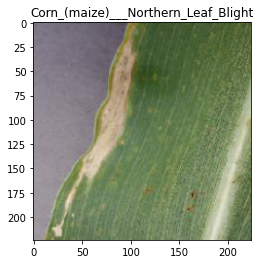

In [ ]:
for image_batch, label_batch in trainDset:
    plt.imshow(image_batch[0])
    plt.title(class_name[int(label_batch[0])])
    break

#here the image is augumented image not the original image from dataset since we are here using image data generator

## Transfer learning

Donwloading the weight for densenet model here imagnet weights are used.

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, CHANNEL)
num_classes = len(class_name)
#importing the resnet library
resnet = ResNet50V2(input_shape = input_shape, weights = 'imagenet', include_top = False )

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
#inorder to not train all layers
for layer in resnet.layers:
  layer.trainable = False


In [ ]:
#adding layers
resnet_layer = Flatten()(resnet.output)

final_layer = Dense(units = num_classes, activation = 'softmax')(resnet_layer)

#create a model
model = Model(resnet.input, outputs = final_layer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#compiling the model
model.compile(
    optimizer = 'adam',
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy']
)

In [ ]:
#fit the model

hist = model.fit(
                trainDset,
                steps_per_epoch = len(trainDset),
                epochs = 5,
                verbose = 1,
                #batch_size = BATCH_SIZE,
                validation_data = valDset,
                validation_steps = len(valDset)
)

Epoch 1/5
635/635 [==============================] - 1843s 3s/step - loss: 3.2136 - accuracy: 0.8436 - val_loss: 5.1128 - val_accuracy: 0.8521
Epoch 2/5
635/635 [==============================] - 1738s 3s/step - loss: 2.1463 - accuracy: 0.9260 - val_loss: 3.1372 - val_accuracy: 0.9109
Epoch 3/5
635/635 [==============================] - 1752s 3s/step - loss: 2.0218 - accuracy: 0.9346 - val_loss: 2.3124 - val_accuracy: 0.9378
Epoch 4/5
635/635 [==============================] - 1721s 3s/step - loss: 1.7101 - accuracy: 0.9491 - val_loss: 2.2924 - val_accuracy: 0.9475
Epoch 5/5
635/635 [==============================] - 1722s 3s/step - loss: 1.5042 - accuracy: 0.9539 - val_loss: 3.3290 - val_accuracy: 0.9281


Testing model on test dataset

In [ ]:
scores = model.evaluate(testDset)

183/183 [==============================] - 817s 4s/step - loss: 3.1659 - accuracy: 0.9317


In [ ]:
scores

[3.1658668518066406, 0.9317089915275574]

Accuracy of the model is 93.17%

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

Visualising the traing and validation accuracy and loss over the epochs

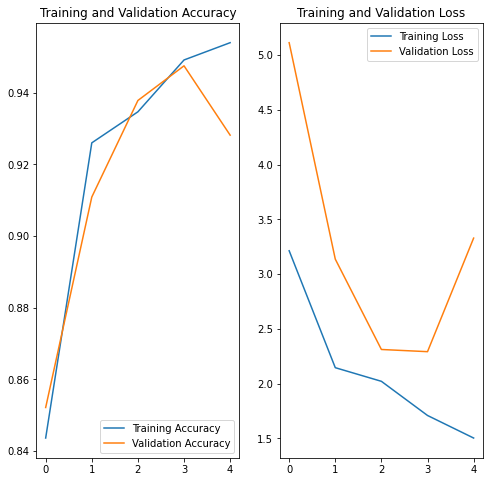

In [ ]:
EPOCHS = 5

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predicting the diseases and confidence

Actual diseases: Corn_(maize)___Northern_Leaf_Blight
Predicited disease: Corn_(maize)___Northern_Leaf_Blight
Confidence 100.0 %


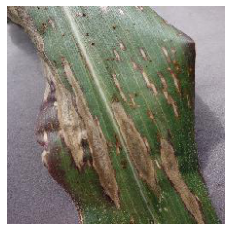

In [ ]:
for image_batch, label_batch in testDset:
    first_image = image_batch[0]
    first_label = class_name[int(label_batch[0])]
    
    
    plt.imshow(first_image)
    print("Actual diseases:",first_label)
    
    batch_prediction = model.predict(image_batch)
    confidence = round(100 * (np.max(batch_prediction[0])), 2)
    print("Predicited disease:",class_name[np.argmax(batch_prediction[0])])
    print("Confidence", confidence , "%")
    plt.axis('off')
    
    break

In [ ]:
#saving the model
model.save('resnet.h5')